## Using density ratios on data with different supports

If both distributions have different supports we face a problem since we can find values in which the ratio $f(s(x))/g(s(x))$ become 0 or inf. This problem is inherent to the use of density ratios in reweighting or covariate shift methods. We can easily solve it by transforming data from $g(x)$ (the distribution being reweighted) using 
$$y^g = \frac{(x^g - x_{min}^g)*(x_{max}^f - x_{min}^f)}{x^g_{max} - x^g_{min}} + x_{min}^f $$
where $x^g \sim g(x)$ and $x^f \sim f(x)$.

Then the ratio $f(x)/g'(x)$ can be computed where $g'(x)$ is the distribution on the transformed data. Reweighting data from $g(x)$ transformed using the same min and max values allows to recover $f(x)$.

The problem is to know the min and max values of the distributions, in some cases those values can be known in advance.

In the next notebook we show how this works on 1-dim data.

In [58]:
import ROOT
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import cross_validation
from xgboost_wrapper import XGBoostClassifier

import matplotlib.pyplot as plt

from mlp import make_predictions, train_mlp
from utils import printFrame,makePlotName,makeSigBkg,saveFig

import numpy as np

import os

%matplotlib inline

Some global parameters (classifier used, number of features, ...)

In [59]:
workspace_file = 'workspace_transfer.root'
vars_g = ['x']
dir='.'
model_g='mlp'
verbose_printing=False
seed = 1234
rng = np.random.RandomState(seed)

Defining the distribution $f(x)$ and $g(x)$.

In [60]:
# Statistical model
w = ROOT.RooWorkspace('w')
w.factory("EXPR::f0('exp(-(x-10.5)**2/1.)',x[0,15])")
w.factory("EXPR::f1('exp(-(x-3.5)**2/5.)',x)")


# Check Model
w.Print()
if verbose_printing == True:
     printFrame(w,['x'],[w.pdf('f0'),w.pdf('f1')],'transfered',['f0','f1']
    ,dir=dir,model_g=model_g,range=[-15,20],title='Single distributions',x_text='x0',y_text='p(x)',
     print_pdf=True)

Generating data from $f(x)$ and $g(x)$. Generating data from $g'(x)$ using the previously mentioned transformation.

Making Data


[]

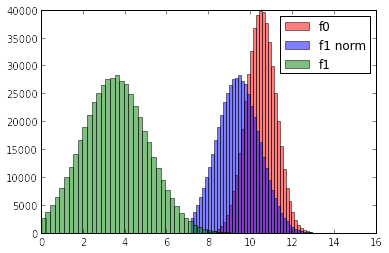

In [61]:
# Start generating data
num_train = 500000
num_test = 5000
no_train = False
num_train_1 = num_train #f0
num_train_2 = num_train #f1

print 'Making Data'
# Start generating data

   
# make data from root pdf
def makeDataFi(x, pdf, num):
    traindata = np.zeros((num,len(vars_g))) 
    data = pdf.generate(x,num)
    traindata[:] = [[data.get(i).getRealValue(var) for var in vars_g]
        for i in range(num)]
    return traindata
  
  # features
vars = ROOT.TList()
for var in vars_g:
    vars.Add(w.var(var))
x = ROOT.RooArgSet(vars)


train_data = np.zeros((num_train_1 + num_train_2,len(vars_g) + 1))
test_data = np.zeros((num_test*2,len(vars_g) + 1))
train_data_unorm = np.zeros((num_train*2,len(vars_g) + 1))
test_data_unorm = np.zeros((num_test*2,len(vars_g) + 1))
f0_min,f1_min = (0.,0.)
f0_max,f1_max = (1.,1.)
if not no_train:

    data_f0 =  makeDataFi(x,w.pdf('f0'), num_train)
    data_f1 = makeDataFi(x,w.pdf('f1'), num_train)
    train_data_unorm[:num_train_1,:len(vars_g)] =  data_f0
    train_data_unorm[num_train_1:,:len(vars_g)] = data_f1
    #Normalizing
    
    f0_min,f0_max = (data_f0.min(),data_f0.max())
    f1_min,f1_max = (data_f1.min(),data_f1.max())

    a_norm = (f0_max - f0_min)/(f1_max - f1_min)
    b_norm = (f1_min * f0_min - f0_max * f1_min)/(f1_max - f1_min) + f0_min
    
    data_f1_norm = a_norm * data_f1 + b_norm
    # Adding an uniform

    train_data[:num_train_1,:len(vars_g)] = data_f0
    train_data[num_train_1:,:len(vars_g)] = data_f1_norm
 
    train_data[:num_train_1,-1] = np.ones(num_train_1)
    train_data_unorm[:num_train_1,-1] = np.ones(num_train_1)


plt.hist(data_f0,bins=50,color='red',alpha=0.5,label='f0')
plt.hist(data_f1_norm,bins=50,color='blue',alpha=0.5,label='f1 norm')
plt.hist(data_f1,bins=50,color='green',alpha=0.5,label='f1')
plt.legend()
plt.plot()



Train classifier to discriminate between $f(x)$ and $g'(x)$.

In [62]:

model_file = 'train'
n_epochs=40
traindata = train_data[:,:-1]
targetdata = train_data[:,-1]
if model_g == 'mlp':
    train_mlp((traindata, targetdata), save_file='{0}/{1}_F0_F1.pkl'.format(dir,model_file),n_epochs=n_epochs,
             n_hidden=10)
else:
    indices = rng.permutation(traindata.shape[0])
    traindata = traindata[indices]
    targetdata = targetdata[indices]
    scores = cross_validation.cross_val_score(clf, traindata, targetdata)
    print "Accuracy: {0} (+/- {1})".format(scores.mean(), scores.std() * 2)
    clf.fit(traindata,targetdata)
    #clf.plot_importance_matrix(vars_names)
    joblib.dump(clf, '{0}/{1}_F0_F1.pkl'.format(dir,model_file))


... building the model
... training
Epoch: 1, cost: 277.2518659
Epoch: 2, cost: 278.556830651
Epoch: 3, cost: 278.644855192
Epoch: 4, cost: 278.731772661
Epoch: 5, cost: 278.747604939
Epoch: 6, cost: 278.66281369
Epoch: 7, cost: 277.477282789
Epoch: 8, cost: 271.729845564
Epoch: 9, cost: 228.058540848
Epoch: 10, cost: 219.323725701
Epoch: 11, cost: 217.876125665
Epoch: 12, cost: 217.321432321
Epoch: 13, cost: 217.036709439
Epoch: 14, cost: 215.930206168
Epoch: 15, cost: 214.592987741
Epoch: 16, cost: 213.988858436
Epoch: 17, cost: 212.833381503
Epoch: 18, cost: 212.183230207
Epoch: 19, cost: 211.728904883
Epoch: 20, cost: 211.315972353
Epoch: 21, cost: 210.953201208
Epoch: 22, cost: 210.701127786
Epoch: 23, cost: 210.516920192
Epoch: 24, cost: 210.375575239
Epoch: 25, cost: 210.265066571
Epoch: 26, cost: 210.177093066
Epoch: 27, cost: 210.105838793
Epoch: 28, cost: 210.0472049
Epoch: 29, cost: 209.998257681
Epoch: 30, cost: 209.956863904
Epoch: 31, cost: 209.921454435
Epoch: 32, cost: 

In [63]:
# Prediction function 
def predict(filename, traindata,model_g='mlp', sig=1):
  sfilename,k,j = filename.split('/')[-1].split('_')
  sfilename = '/'.join(filename.split('/')[:-1]) + '/' +  sfilename
  j = j.split('.')[0]
  sig = 1
  if k <> 'F0':
    k = int(k)
    j = int(j)
    sig = 1 if k < j else 0
    filename = '{0}_{1}_{2}.pkl'.format(sfilename,min(k,j),max(k,j))
  if model_g == 'mlp':
    return make_predictions(dataset=traindata, model_file=filename,n_hidden=10)[:,sig]
  else:
    clf = joblib.load(filename)
    if clf.__class__.__name__ == 'NuSVR':
      output = clf.predict(traindata)
      return np.clip(output,0.,1.)
    else:
      return clf.predict_proba(traindata)[:,sig]


Estimate distributions $f(s(x))$ and $g'(s(x))$.

In [64]:

bins = 80
low = 0.
high = 1.  
c1_g=''
print 'Generating Score Histograms'

w.factory('score[{0},{1}]'.format(low,high))
s = w.var('score')
  
def saveHisto(w,outputs,s,bins,low,high,k='F0',j='F1'):
    
    print 'Estimating {0} {1}'.format(k,j)
    for l,name in enumerate(['sig','bkg']):
      data = ROOT.RooDataSet('{0}data_{1}_{2}'.format(name,k,j),"data",
          ROOT.RooArgSet(s))
      hist = ROOT.TH1F('{0}hist_{1}_{2}'.format(name,k,j),'hist',bins,low,high)
      values = outputs[l]
      #values = values[self.findOutliers(values)]
      for val in values:
        hist.Fill(val)
        s.setVal(val)
        data.add(ROOT.RooArgSet(s))
      norm = 1./hist.Integral()
      hist.Scale(norm) 
        
      s.setBins(bins)
      datahist = ROOT.RooDataHist('{0}datahist_{1}_{2}'.format(name,k,j),'hist',
            ROOT.RooArgList(s),hist)
      histpdf = ROOT.RooHistFunc('{0}histpdf_{1}_{2}'.format(name,k,j),'hist',
            ROOT.RooArgSet(s), datahist, 1)

      getattr(w,'import')(hist)
      getattr(w,'import')(data)
      getattr(w,'import')(datahist) # work around for morph = w.import(morph)
      getattr(w,'import')(histpdf) # work around for morph = w.import(morph)
      score_str = 'score'
      # Calculate the density of the classifier output using kernel density 
      #w.factory('KeysPdf::{0}dist_{1}_{2}({3},{0}data_{1}_{2},RooKeysPdf::NoMirror,2)'.format(name,k,j,score_str))



print 'F0/F1'
outputs = [predict('/afs/cern.ch/work/j/jpavezse/private/transfer_learning/{0}_F0_F1.pkl'.format(model_file),
                   traindata[targetdata==1],model_g=model_g),
            predict('/afs/cern.ch/work/j/jpavezse/private/transfer_learning/{0}_F0_F1.pkl'.format(model_file),
                    traindata[targetdata==0],model_g=model_g)]

saveHisto(w,outputs,s, bins, low, high)


if verbose_printing == True:
    can = printFrame(w,['score'],[w.function('sighistpdf_F0_F1'),w.function('bkghistpdf_F0_F1')], makePlotName('full',
    'all',type='hist',dir=dir,c1_g=c1_g,model_g=model_g),['signal','bkg'],
  dir=dir,model_g=model_g,y_text='score(x)',print_pdf=True,title='Pairwise score distributions',use_rootnotes=False)


Generating Score Histograms
F0/F1
Estimating F0 F1


In [65]:
def findOutliers(x):
  q5, q95 = np.percentile(x, [5,95])  
  iqr = 2.*(q95 - q5)
  outliers = (x <= q95 + iqr) & (x >= q5 - iqr)
  return outliers
def singleRatio(f0,f1):
  ratio = f1 / f0
  ratio[np.abs(ratio) == np.inf] = 0 
  ratio[np.isnan(ratio)] = 0
  return ratio

def evalDist(x,f0,val):
  iter = x.createIterator()
  v = iter.Next()
  i = 0
  while v:
    v.setVal(val[i])
    v = iter.Next()
    i = i+1
  return f0.getVal(x)

Estimate $f(x)$ using the ratio $f(s(x)) / g'(s(x))$ in order to reweight data $y^g$.

Calculating ratios
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   5.99447188e+00
   1.67636103e+01   2.28925097e+01   3.02561509e+01   3.90536856e+01
   5.09893242e+01   7.12115391e+01   1.21055980e+02   2.91113380e+02
   6.47780231e+

[]

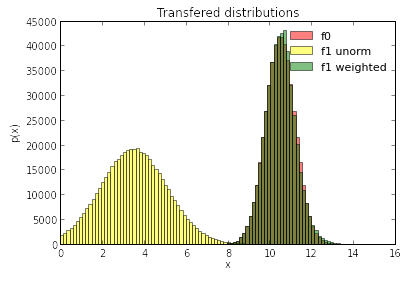

In [67]:

print 'Calculating ratios'
true_dist = True
npoints = 50

score = ROOT.RooArgSet(w.var('score'))
getRatio = singleRatio

# NN trained on complete model
F0pdf = w.function('bkghistpdf_F0_F1')
F1pdf = w.function('sighistpdf_F0_F1')


if true_dist == True and len(vars_g) == 1:
    xarray = np.linspace(1.,15.,npoints)
    # TODO: Harcoded dist names
    #F1dist = np.array([evalDist(x,w.pdf('f1'),[xs]) for xs in xarray])
    #F0dist = np.array([evalDist(x,w.pdf('f0'),[xs]) for xs in xarray])
    #trueRatio = getRatio(F1dist, F0dist)

    outputs = predict('{0}/{1}_F0_F1.pkl'.format(dir,model_file),xarray,model_g=model_g)
    F1fulldist = np.array([evalDist(score,F1pdf,[xs]) for xs in outputs])
    F0fulldist = np.array([evalDist(score,F0pdf,[xs]) for xs in outputs])

    completeRatio = getRatio(F0fulldist,F1fulldist)
    
    #plt.plot(xarray, completeRatio)
    #plt.plot(xarray, trueRatio)
    #saveFig(xarray, [completeRatio, trueRatio], makePlotName('all',
    #'train',type='ratio'),title='Density Ratios',labels=['Trained', 'Truth'], print_pdf=True,dir=dir)
  

# Make transfer learning

# Transforming f1 into f0
data_f1 = train_data[train_data[:,-1] == 0.]
data_f0 = train_data[train_data[:,-1] == 1.]
data_f1_unorm = train_data_unorm[train_data_unorm[:,-1] == 0.]

xarray = data_f1[:,:-1]

outputs = predict('{0}/{1}_F0_F1.pkl'.format(dir,model_file),xarray,model_g=model_g)

F1fulldist = np.array([evalDist(score,F1pdf,[xs]) for xs in outputs])
F0fulldist = np.array([evalDist(score,F0pdf,[xs]) for xs in outputs])

completeRatio = getRatio(F0fulldist,F1fulldist)

if len(vars_g) == 1:
    F1dist = np.array([evalDist(x,w.pdf('f1'),[xs]) for xs in xarray])
    F0dist = np.array([evalDist(x,w.pdf('f0'),[xs]) for xs in xarray])
else:
    F1dist = np.array([evalDist(x,w.pdf('f1'),xs) for xs in xarray])
    F0dist = np.array([evalDist(x,w.pdf('f0'),xs) for xs in xarray])

trueRatio = getRatio(F1dist, F0dist)


bins = 100
feature = 0
x_range = (0.,15.)
# Transfering distributions
# Doing histogram manipulation
fig,ax = plt.subplots()
colors = ['b-','r-','k-']
colors_rgb = ['blue','red','black']
alpha = 0.5
beta = 0.5

#data_f1_red = ((data_f1 - f0_min)*(f1_max-f1_min))/(f0_max-f0_min) + f1_min
#data_f1_red = (data_f1 - a_norm) / b_norm

hist,bins = np.histogram(data_f1[:,feature],bins=bins, range=x_range)
hist_transfered,bins_1 = np.histogram(data_f1[:,feature],weights=trueRatio,bins=bins, range=x_range)

hist_transfered_clf,bins_2 = np.histogram(data_f1[:,feature],bins=bins,
                                          weights=completeRatio, range=x_range)

hist0,bins0 = np.histogram(data_f0[:,feature], bins=bins, range=x_range)
hist1_unorm,bins_norm = np.histogram(data_f1_unorm[:,feature],bins=bins, range=x_range)

print hist_transfered_clf

widths = np.diff(bins)


ax.bar(bins[:-1], hist0,widths,label='f0',alpha=0.5,color='red')
ax.bar(bins[:-1], hist1_unorm,widths,label='f1 unorm',alpha=0.5,color='yellow')
#ax.bar(bins[:-1], hist,widths,label='f1',alpha=0.5,color='blue')
#ax.bar(bins[:-1], hist_transfered,widths,label='f1 weighted (true)',
#    alpha=0.5,color='green')
ax.bar(bins[:-1], hist_transfered_clf,widths,label='f1 weighted ',
        alpha=0.5,color='green')

ax.legend(frameon=False,fontsize=11)
ax.set_xlabel('x') 
ax.set_ylabel('p(x)') 
if len(vars_g) > 1:
    ax.set_title('Transfered distributions feature {0}'.format(feature))
else:
    ax.set_title('Transfered distributions')
file_plot =  makePlotName('all','transf',type='hist_v{0}'.format(feature),model_g=model_g) 
fig.savefig('{0}/plots/{1}/{2}.png'.format(dir,model_g,file_plot))

#saveFig(xarray, [true_transfer, data_f0[:,0]], makePlotName('all','transf',type='hist'),title='Transfered distribution',labels=['Transfer True', 'Truth'],hist=True, print_pdf=True,dir=dir)
plt.plot()